In [1]:
# Set up autoreload
%load_ext autoreload
%autoreload 2

### Import Libraries

In [2]:
# Natural Language Libraries
import nltk
from nltk.corpus import opinion_lexicon

# Scikit-Learn
from sklearn.linear_model import SGDClassifier
# Data Handling
import pandas as pd

import json
from joblib import load

# Custom Modules
from pre_processing import *
from feature_extraction import *
from glove_controller import *
from evaluation import *

### Constants and Supplementary Data

In [3]:
# Random Seed
RANDOM_STATE = 123

# Positive and Negative words lexicon
positive_words = set(opinion_lexicon.positive())
negative_words = set(opinion_lexicon.negative())

# Sarcasm Classifier Load
sarcasm_model = load("../../data/sarcasm_model.pkl")
sarcasm_vec = load("../../data/dict_vectorizer.pkl")

# Load profanity list
with open('../../data/profanity.txt', 'r') as f:
    profanity_words = [s.strip() for s in f.readlines()]

# Load slang list
with open('../../data/slang.txt', 'r') as f:
    slang_words = [s.strip() for s in f.readlines()]

# Set punctuation list
punct_list = ['!','#','@','?']

# Load emoji sentiment
with open("../../data/emoji_polarity.json", "r", encoding="utf-8") as f:
    emoji_json = json.load(f)

# Load emoticon sentiment
with open("../../data/emoticon_polarity.json", "r", encoding="utf-8") as f:
    emoticon_json = json.load(f)
combined_sentiment = {**emoji_json, **emoticon_json}

# Define GloVe variables
glove_path = r"C:\Users\eggle\Downloads\glove.twitter.27B\glove.twitter.27B.200d.txt"
EMBED_DIM = 200 

### Load Datasets

In [4]:
df_train = pd.read_csv('../../data/twitter_sentiment_train.csv')
df_test  = pd.read_csv('../../data/twitter_sentiment_test.csv')

# Shuffle train set
df_train = df_train.sample(frac=1, random_state=RANDOM_STATE).reset_index(drop=True)

### Apply preprocessing to Datasets

In [5]:
# Apply preprocessing to the datasets
clean_tokens_train = [preprocessing_text(t) for t in df_train['text']]
clean_tokens_test = [preprocessing_text(t) for t in df_test['text']]
clean_text_train = [' '.join(tokens) for tokens in clean_tokens_train]
clean_text_test = [' '.join(tokens) for tokens in clean_tokens_test]

### Feature Extraction

In [6]:
# Define Custom functions
feature_functions = [
    lambda text: count_specified_punctuations(text, punct_list),
    lambda text: count_profanity_words(text, profanity_words),
    lambda text: count_slang_words(text, slang_words),   
    count_all_capital_tokens,
    count_not,
    count_sad_emoticons,
    # count_happy_emoticons,
    # count_elongated_words,
    # lambda text: count_positive_words(text, positive_words),
    # lambda text: count_negative_words(text, negative_words),
    # uppercase_ratio,
    # count_pos_tags,
    # count_named_entities,
    # lambda text: get_sentiment_and_subjectivity(text, combined_sentiment),
    # get_hashtag_polarities,
    # lambda text: predict_sarcasm(text, sarcasm_vec, sarcasm_model),
    # tweet_word_count,
    # tweet_avg_word_length,
]

# Process datasets with TF-IDF
# tfidf_train, tfidf_test, vectorizer = tfidf_features(clean_text_train, clean_text_test, (1,2), 3100)

# Load GloVe model
glove_vectors = load_glove(glove_path, EMBED_DIM)

Loading GloVe: 1193514it [00:49, 23871.70it/s]


In [7]:
# Create glove feature matrices
glove_train = np.vstack([tweet_to_glove_vector(t, glove_vectors, EMBED_DIM) for t in tqdm(clean_text_train, desc="Embedding train")])
glove_test  = np.vstack([tweet_to_glove_vector(t, glove_vectors, EMBED_DIM) for t in tqdm(clean_text_test, desc="Embedding test")])

glove_train = pd.DataFrame(glove_train, columns=[f"glv_{i}" for i in range(EMBED_DIM)])
glove_test  = pd.DataFrame(glove_test,  columns=[f"glv_{i}" for i in range(EMBED_DIM)])

Embedding test: 100%|██████████| 6347/6347 [00:00<00:00, 60079.01it/s]


#### Concatenate all features together (TF-IDF + GloVe + Custom Features)

In [8]:
X_train = df_train[['text']].copy()
X_test  = df_test[['text']].copy()

# Extract Custom Features
for func in tqdm(feature_functions, desc="Computing custom features"):
    results = X_train['text'].apply(lambda x: func(str(x))).tolist()
    X_train = pd.concat([X_train, pd.DataFrame(results)], axis=1)
    results = X_test['text'].apply(lambda x: func(str(x))).tolist()
    X_test = pd.concat([X_test, pd.DataFrame(results)], axis=1)

# Drop column name
X_train_custom = X_train.drop(columns=['text'])
X_test_custom  = X_test.drop(columns=['text'])

# Concat Custom Features with GloVE embeddings
X_train_final = pd.concat([glove_train.reset_index(drop=True), X_train_custom.reset_index(drop=True)], axis=1)
X_test_final  = pd.concat([glove_test.reset_index(drop=True),  X_test_custom.reset_index(drop=True)], axis=1)

X_train_final.columns = X_train_final.columns.astype(str)
X_test_final.columns  = X_test_final.columns.astype(str)
y_train = df_train['label']
y_test  = df_test['label']

Computing custom features: 100%|██████████| 6/6 [00:53<00:00,  8.86s/it]


### Train and Evaluate Logistic Regression


=== Model Evaluation ===
Accuracy: 0.8663935717661887
              precision    recall  f1-score   support

    negative       0.87      0.93      0.90      3972
    positive       0.87      0.76      0.81      2375

    accuracy                           0.87      6347
   macro avg       0.87      0.84      0.85      6347
weighted avg       0.87      0.87      0.86      6347



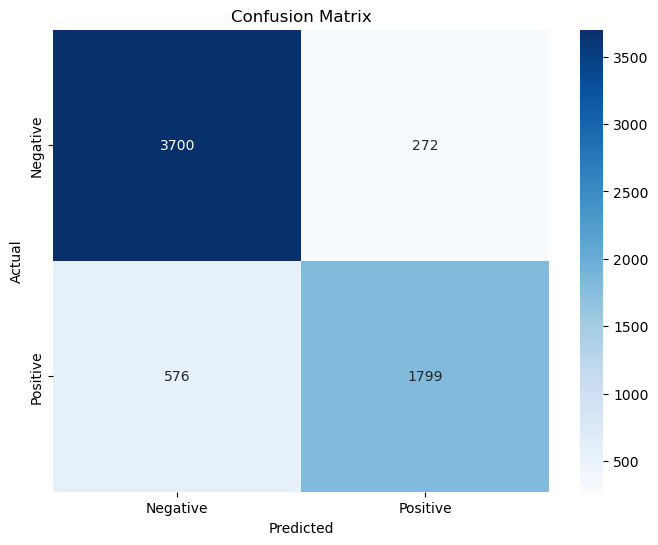

In [9]:
# HyperParameter Initialization
best_params = {
    'alpha' : 0.0006492,
    'eta0' : 0.03049,
    'learning_rate' : 'adaptive'
}

# Initialize Model
final_model = SGDClassifier(
    loss='log_loss',
    alpha=best_params['alpha'],
    eta0=best_params['eta0'],
    learning_rate=best_params['learning_rate'],
    max_iter=5000,
    random_state=RANDOM_STATE,
    tol=1e-3
)

# Train
final_model.fit(X_train_final, y_train)

# Get predictions
y_pred = final_model.predict(X_test_final)

# Print report
evaluate_model(y_test, y_pred)

# Generate confusion matrix
plot_confusion_matrix(y_test, y_pred)


### Feature Evaluation and Missclassified Tweets


Top 25 Most Important Features:
     feature  importance
139  glv_139    0.028975
147  glv_147    0.025786
109  glv_109    0.025217
51    glv_51    0.018204
118  glv_118    0.017038
117  glv_117    0.016579
131  glv_131    0.013320
73    glv_73    0.013218
56    glv_56    0.010997
197  glv_197    0.010879
68    glv_68    0.010726
138  glv_138    0.010692
113  glv_113    0.010676
114  glv_114    0.010169
88    glv_88    0.009892
50    glv_50    0.009709
93    glv_93    0.009438
123  glv_123    0.008850
200        !    0.008727
134  glv_134    0.008106
125  glv_125    0.007991
28    glv_28    0.007912
120  glv_120    0.007786
96    glv_96    0.007345
156  glv_156    0.006972


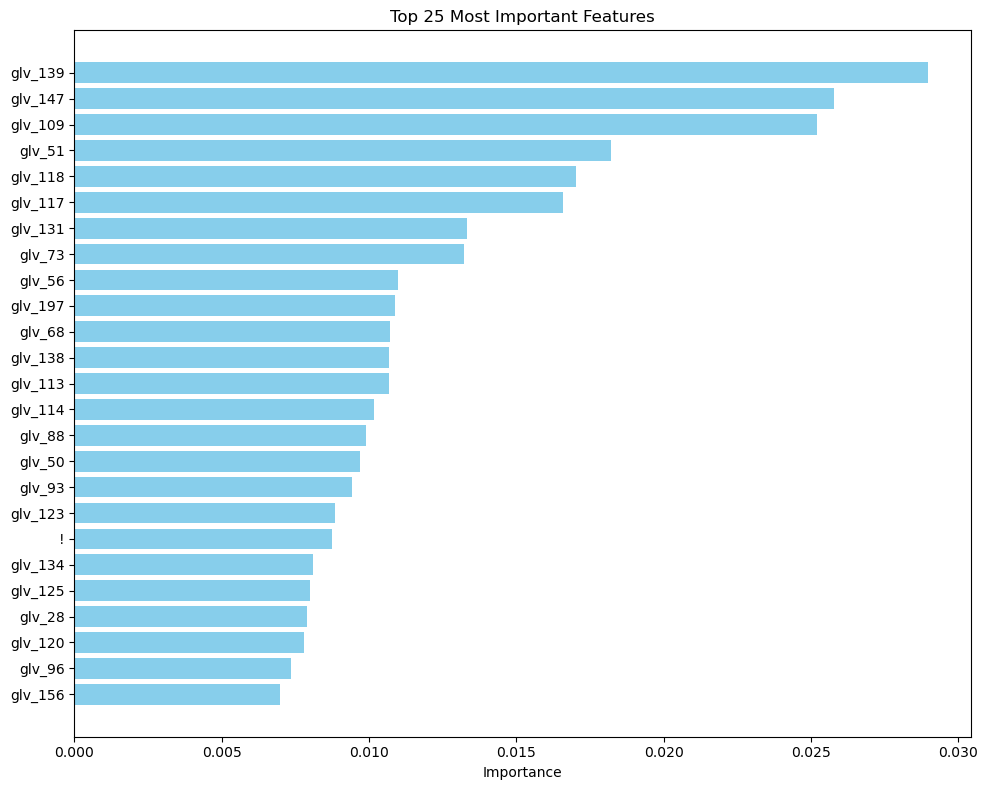


Total Misclassified: 848 out of 6347 (13.36%)

Example 1:
  Text: @user Wow,first Hugo Chavez and now Fidel Castro. Danny Glover, Michael Moore, Oliver Stone, and Sean Penn are running out of heroes.
  True Label: Negative
  Predicted: Positive
  ----------------------------------------------------------------------------

Example 2:
  Text: @user Yes, white supremacists are America's greatest problem ever.  OMG.  GET REAL.  #GOAWAY
  True Label: Negative
  Predicted: Positive
  ----------------------------------------------------------------------------

Example 3:
  Text: #NoDAPL #CorporateGreed #corporations are #evil especially the media #corporations #tpp #TrumpTrain #bravo #cnn #foxnews #soulless #wrong 😣
  True Label: Negative
  Predicted: Positive
  ----------------------------------------------------------------------------

Example 4:
  Text: @user Wow...this is one deadly statement! Reminding me of the Greta Muhammad Ali.
  True Label: Positive
  Predicted: Negative
  -----

In [11]:
# Plot in bar chart feature importance
plot_feature_importance(
    get_feature_importance(X_train_final, y_train, 25, RANDOM_STATE), 
    25
)

# Print missclassified tweets
analyze_misclassifications(y_test, y_pred, df_test)